# CNN visualization of intermediate steps using Saliency maps 

Using TensorFlow 2.0 and Keras

Based on the CIFAR-10 deep neural network prepared in the CnnCifar10 notebook ([HTML](CnnCifar10.html) / [Jupyter](CnnCifar10.ipynb)). 

Part 1's visualizations ([HTML](CnnVisualization-1-Activations.html) / [Jupyter](CnnVisualization-1-Activations.ipynb)) based on activation maps have shown there limits. Let's try some more advanced techniques.

Learning goals:
- saliency maps
- attribution maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, losses, models
import tensorflow as tf
import seaborn as sns

In [2]:
if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Data : CIFAR-10

Images are normalized to $[0, 1]$

In [3]:
(xTrain, yTrain),(xTest, yTest) = datasets.cifar10.load_data()
xTrain = xTrain / 255.
xTest  = xTest  / 255.

classNames = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

xTrain.shape, xTest.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

# Model

In [4]:
model0 = models.load_model('models/CIFAR-10_CNN5.h5')
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

# Helpers

In [48]:
def predictUntilLayer(model, layerIndex, data):
    """ Execute prediction on a portion of the model """
    intermediateModel = models.Model(inputs=model.input,
                                 outputs=model.layers[layerIndex].output)
    return intermediateModel.predict(data)
    
def plotSaliencyMap(original, saliencies, layerNames, dimensions = (32, 32, 3), title="Input"):
    """ Plot saliency map and comparison to input """
    n = len(saliencies)
    fig, axes = plt.subplots(n, 3, figsize=(16, 4*n))
    axes[0][0].imshow(original.reshape(dimensions))
    axes[0][0].set_title(title)
    
    for i in range(n):
        axes[i][1].imshow(saliencies[i].reshape(dimensions))
        axes[i][1].set_title("%s Saliency" % layerNames[i])
        axes[i][2].imshow(np.clip((saliencies[i] - original).reshape(dimensions), 0, 1))
        axes[i][2].set_title("Saliency - Input")
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)

# Network saliency maps

Original saliency map paper [2, section 3] called it "Activation maximization". Activation is reinforced through gradient ascent in order to maximize :
$$ x^* = \arg \max_{x s.t. \Vert x \Vert = \rho} h_{ij}(θ,x)$$

In which : 
- $h_{ij}$ is the unit #j of the layer #i
- $x$ is element of the image space ($\in \mathbb{R}^p \times \mathbb{R}^q$, p and q being the width and height)
- $\theta$ are the coefficients of the unit

This problem is very difficult to tackle with a numerical optimizer.

A sub-optimal solution is sought through gradient ascent. 

In [2], gradient ascent is performed 9 times on random picked test samples.

In [3] the saliency maps is computed only on a modified softmax layer in order to compute the best activation for a given class. 

We turn this problem back to the classic minimization of the deep neural network : 
- select a target class $c$ to detect
- compute the loss using cross-entropy versus the selected class, add regularization terms
- compute corresponding gradients
- substract gradient on input image

$$ \mathcal{I}  = \mathcal{I} - \epsilon \nabla_{\mathcal{I}}(y = c) $$

In which :
- $\mathcal{I}$ is the input image to transform as a saliency map. Initialized as a neutral black or grey
- $c$ is the target class on which we want to figure out saliency maps
- $\epsilon$ is the learning rate of the gradient descent

It is a DNN training in which the network coefficients are frozen, and the weights to optimize are the pixels of the input.

In [21]:
@tf.function
def gradientMinLossStep(model, img, learningRate, lambdaReg, trueActivation, loss):
    """ Minimize error using backpropagation """
    with tf.GradientTape() as tape:
        tape.watch(img)
        tape.watch(trueActivation)
        activation = model(img) 
        imgNorm = tf.norm(img, 'euclidean')
        # Loss + regularization
        objective = loss(trueActivation, activation) + tf.cast(lambdaReg * imgNorm, tf.float32) 
    grads = tape.gradient(objective, img)
    
    # Gradient descent to minimize objective (cross entropy)
    img = img - learningRate * grads 
    
    return objective, grads, img, imgNorm

def getGlobalSalient(numEpochs, model, img, learningRate, lambdaReg, trueActivation=None):
    
    imgTf = tf.expand_dims(img, axis=0)
    trueActivationTf = tf.constant(trueActivation.reshape(1, -1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
        
    intensityHist, gradHist, imgNorms = [], [], []
    
    for epoch in range(numEpochs):
       
        intensity, grads, imgTf, imgNorm = gradientMinLossStep(model, imgTf, learningRate, 
                                                               lambdaReg, trueActivationTf, loss)
        
        intensityHist.append(intensity)
        gradHist.append(grads)
        imgNorms.append(imgNorm)
    
    # Only clip the returned saliency image
    return (tf.clip_by_value(imgTf, 0, 1)[0], intensityHist, gradHist, imgNorms)

Apply on neutral grey image

In [22]:
mediumGray = np.ones((32, 32, 3)) * 0.2
globalSaliencies = []

for c in range(10):
    globalSaliencies.append(getGlobalSalient(500, model0, mediumGray, 0.05, 1e-3, np.array([c * 1.]))) 

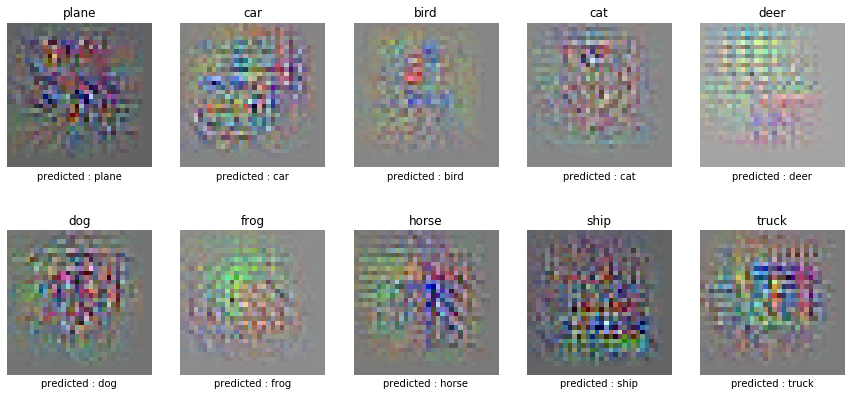

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for c, sal, ax in zip(classNames, globalSaliencies, axes.ravel()):
    ax.imshow(sal[0] / sal[0].numpy().max()) 
    ax.set_title(c)
    pred = model0.predict(sal[0].numpy().reshape(1, 32, 32, 3))
    ax.set_xlabel("predicted : %s" % classNames[np.argmax(pred)])
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

### Apply saliency map to a test image

Salient images are multiplied to a test image and used as input to the model for predictions.

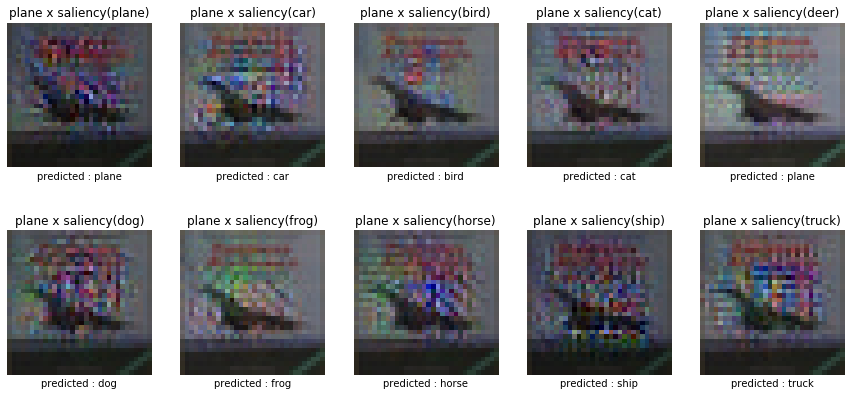

In [9]:
testImgIndex =  3
sampleInput = xTest[testImgIndex]
sampleClass = classNames[yTest[testImgIndex][0]]

fig, axes = plt.subplots(2, 5, figsize=(15, 7))
for c, sal, ax in zip(classNames, globalSaliencies, axes.ravel()):
    saliencyVal = sal[0].numpy()
    gradTimesImage = np.multiply(saliencyVal / saliencyVal.max(), sampleInput)
    gradTimesImage = gradTimesImage #/ gradTimesImage.max()
    ax.imshow(gradTimesImage) 
    ax.set_title("%s x saliency(%s)" % (sampleClass, c))
    pred = model0.predict(gradTimesImage.reshape(1, 32, 32, 3))
    ax.set_xlabel("predicted : %s" % classNames[np.argmax(pred)])
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

Almost all modified images are classified as the target class for which the saliency map has been made.

# Selected image saliency

Another way to use saliency maps is to inspect a given layer (or a given unit within a layer) in order to find which input image will lead to the highest activation. In this problem there is no clearly defined goal as there was previously the probability of the target class. The goal is not a minimum but a maximum of intensity on the layer/unit output. Thus this is a gradient ascent as presented in [2] and [3] (with regularization).

$$ \mathcal{I} = \mathcal{I} + \nabla_{\mathcal{I}}^{(l)}(z) - \lambda \Vert \mathcal{I} \Vert_F $$

In which : 
- $\mathcal{I}$ is the input image to transform as a saliency map
- $z$ is either the full layer output or a given unit
- $\lambda$ is the regularization hyper-parameter
- $\Vert . \Vert_F$ if the Frobenius norm

It can be performed on a selected test image. The main interest is to visualize not only the parts of the images that activate the full network but also the ones that activate part of the network.

Following code is inspired by [4] but using Keras and TensorFlow 2.0, and from the Deepdream demo of TensorFlow [5] but without the strange combination of two layers, without the clip on the image pixel values that is inserting some high frequency noise (ripples). Regularization is also added in order to speedup and enhance saliency maps.

We apply this technique on the successive layers of the neural network.

In [41]:
@tf.function
def gradientMaxStep(model, img, learningRate, lambdaReg, unit):
    with tf.GradientTape() as tape:
        tape.watch(img)
        activation = model(img)
        # Select unit if any
        if unit is not None:
            if len(activation.shape) == 4:
                activationTarget = activation[:,:,:,unit]  
            else:
                activationTarget = activation[:,unit]
        else:
            activationTarget = activation
        objective = tf.math.reduce_mean(activationTarget)
    grads = tape.gradient(objective, img)
    imgNorm = tf.norm(img, 'fro', axis=(1, 2)) #fro, euclidean
    
    # Gradient ascent with regularization to maximize intensity
    img = img + learningRate * grads - lambdaReg * imgNorm 
   
    return objective, grads, img, imgNorm

def getPartialSalient(numEpochs, model, img, learningRate, lambdaReg, unit=None):
    
    imgTf = tf.expand_dims(img, axis=0)
    trueActivationTf = None
    loss = None
       
    intensityHist, gradHist, imgNorms = [], [], []
    
    for epoch in range(numEpochs):
       
        intensity, grads, imgTf, imgNorm = gradientMaxStep(model, imgTf, learningRate, lambdaReg, unit)
        
        intensityHist.append(intensity)
        gradHist.append(grads)
        imgNorms.append(imgNorm)
    
    # Only clip the returned saliency image
    return (tf.clip_by_value(imgTf, 0, 1)[0], intensityHist, gradHist, imgNorms)

In [38]:
layerTitles = ['Conv layer #0', 'Conv layer #1', 'Conv layer #2', 'Dense layer #0']
partialModels = [models.Model(inputs=model0.input,
                      outputs=model0.layers[i].output) for i in [0, 2, 4, 7]]

testImgIndex =  17
sampleInput = xTest[testImgIndex]
saliencyRes = []
for m, learningRate in zip(partialModels, [2, 1, 0.1, 0.01]):
    saliencyRes.append(getPartialSalient(1000, m, sampleInput, learningRate, learningRate / 5e5))

Tensor("model_24/conv_0/Relu:0", shape=(1, 30, 30, 32), dtype=float32)
Tensor("model_25/conv_1/Relu:0", shape=(1, 13, 13, 64), dtype=float32)
Tensor("model_26/conv_2/Relu:0", shape=(1, 4, 4, 64), dtype=float32)
Tensor("model_27/dense_0/Relu:0", shape=(1, 64), dtype=float32)


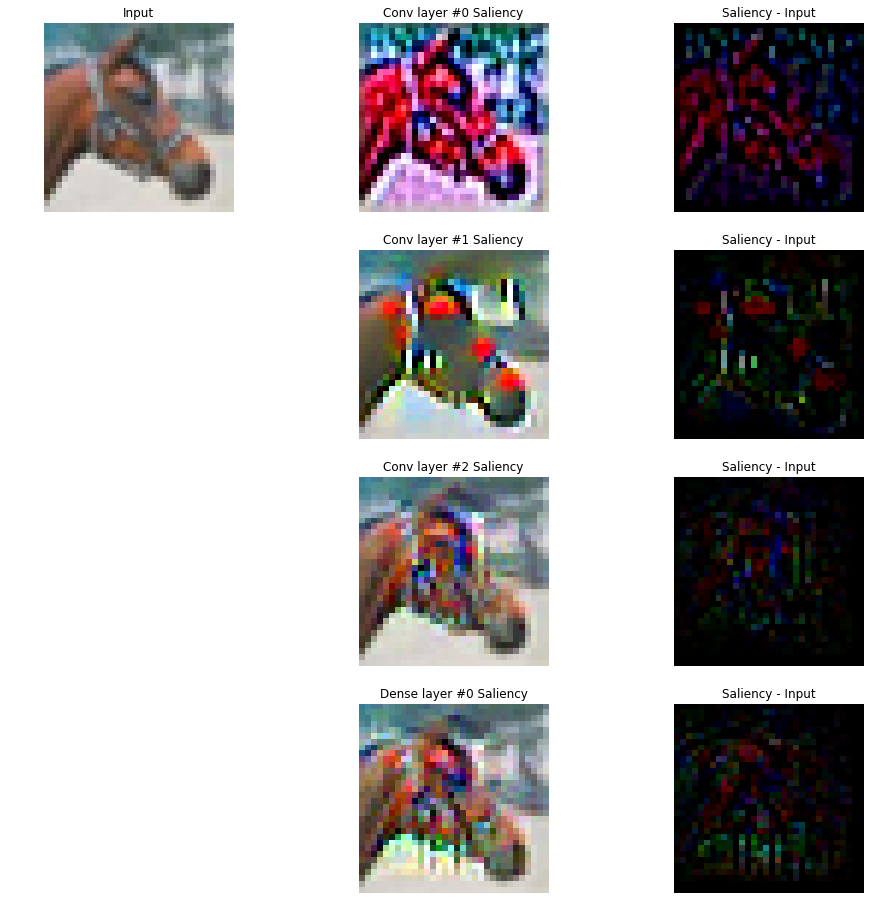

In [39]:
plotSaliencyMap(sampleInput, 
                [saliencyRes[i][0].numpy() for i in range(len(saliencyRes))], 
                layerTitles)

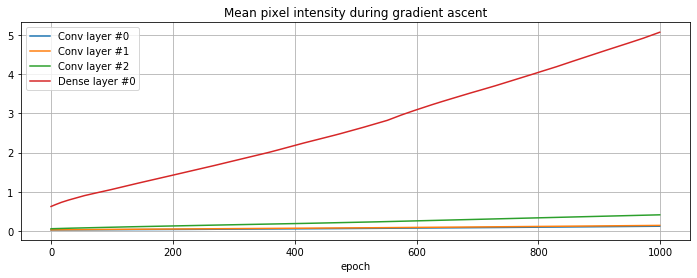

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(len(saliencyRes)):
    ax.plot(saliencyRes[i][1], label=layerTitles[i])
ax.set_title('Mean pixel intensity during gradient ascent')
ax.set_xlabel('epoch')
ax.legend()
ax.grid()

The pixel values are clipped at the end of the saliency processing to $[0,1]$

## Gradient display

-0.005550210364162922 0.0048817228525877


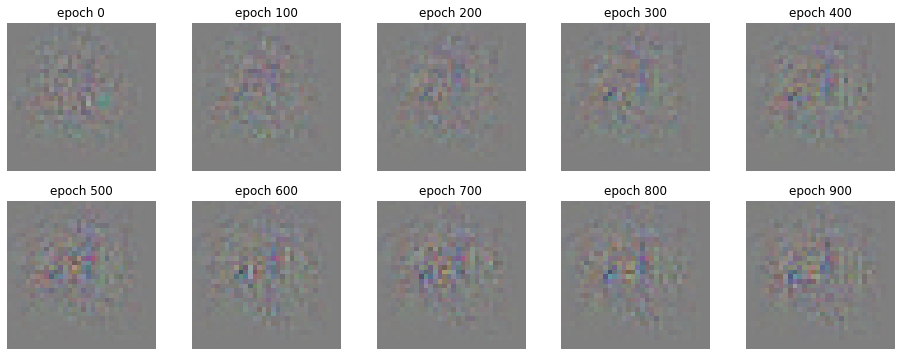

In [32]:
saliencyIndex = 2
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i, ax in enumerate(axes.ravel()):
    epoch = 100 * i
    ax.imshow((saliencyRes[saliencyIndex][2][epoch].numpy() * 20 + 0.5).reshape(32, 32, 3))
    ax.set_title("epoch %d" % epoch)
plt.setp(axes, xticks=[], yticks=[], frame_on=False);

print(np.min(saliencyRes[saliencyIndex][2][100].numpy()), np.max(saliencyRes[saliencyIndex][2][90].numpy()))

## Saliency of a given unit applied on a grey image

If starting from a grey image, since the full hidden layer activation is maximized, we have no idea what the maximization will drive as the layer is supposed to handle all classes.

However we may apply such processing with focus on a given unit within the layer.

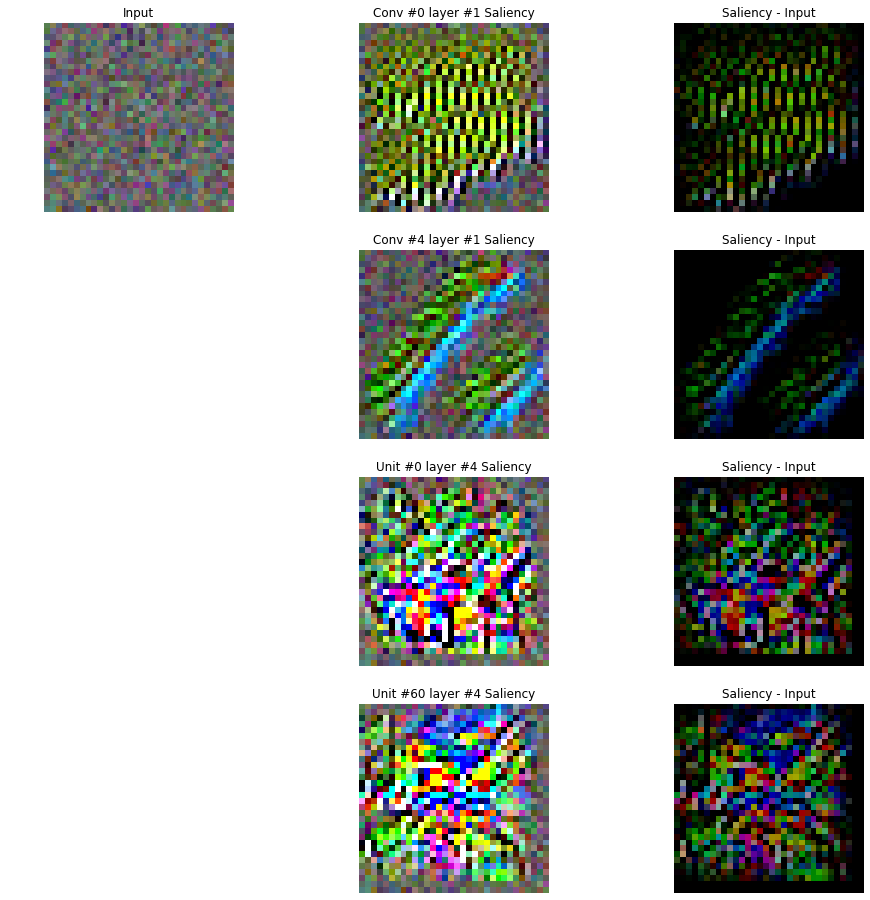

In [78]:
selectedUnits = [0, 4, 0, 60]
partialModels2 = [models.Model(inputs=model0.input,
                      outputs=model0.layers[i].output) for i in [2, 2, 7, 7]]
layerTitles2 = ['Conv #%d layer #1' % selectedUnits[0], 'Conv #%d layer #1' % selectedUnits[1],\
                'Unit #%d layer #4' % selectedUnits[2], 'Unit #%d layer #4' % selectedUnits[3]]

randomIn = np.random.normal(0.4, 0.1, (32, 32, 3))
saliencyResLocal = []
for m, learningRate, unit in zip(partialModels2, [0.2, 0.2, 0.01, 0.01], selectedUnits):
    saliencyResLocal.append(getPartialSalient(1000, m, randomIn, learningRate, learningRate / 5e4, unit))

plotSaliencyMap(randomIn, 
                [saliencyResLocal[i][0].numpy() for i in range(len(saliencyResLocal))], 
                layerTitles2)

## References

1. [Tensorflow tutorial for CNN](https://www.tensorflow.org/tutorials/images/cnn)
2. [Visualizing Higher-Layer Features of a Deep Network, D. Erhan, Y. Bengio, A. Courville, 2009](https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network)
3. [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034.pdf)
4. [Saliency Maps for Deep Learning Part 1: Vanilla Gradient, Andrew Schreiber](https://medium.com/@thelastalias/saliency-maps-for-deep-learning-part-1-vanilla-gradient-1d0665de3284)
5. [DeepDream, Tensorflow documentation](https://www.tensorflow.org/tutorials/generative/deepdream)